[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/elcursodeia-code/blob/master/dl/05_entrenamiento.ipynb)

# Entrenando Redes Neuronales

## Conjuntos de datos

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"].values.astype(np.float32), mnist["target"].values.astype(int)

In [2]:
import torch

class Dataset(torch.utils.data.Dataset):

	# constructor
	def __init__(self, X, Y):
		self.X = torch.tensor(X).float()
		self.Y = torch.tensor(Y).long()

	# cantidad de muestras en el dataset
	def __len__(self):
		return len(self.X)

	# devolvemos el elemento `ix` del dataset
	def __getitem__(self, ix):
		return self.X[ix], self.Y[ix]

In [3]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def train(model, epochs = 30, batch_size=1000, log_each = 10):
	dataset = Dataset(X, Y)
	dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
	model.cuda()
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters())
	l, acc = [], []
	for e in range(1, epochs+1):
		_l, _acc = [], []
		# entrenamiento
		model.train()
		for batch_ix, (x, y) in enumerate(dataloader):
			x, y = x.cuda(), y.cuda()
			optimizer.zero_grad()
			with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
				y_pred = model(x)
				loss = criterion(y_pred, y)
			_l.append(loss.item())
			y_probas = torch.argmax(softmax(y_pred), axis=1)
			_acc.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().detach().numpy()))
			loss.backward()
			optimizer.step()
		l.append(np.mean(_l))
		acc.append(np.mean(_acc))
		loss, current = loss.item(), (batch_ix + 1) * len(x)
		if e % log_each == 0:
			print(f"epoch: {e}/{epochs} loss: {loss:.4f} acc {acc[-1]:.5f}")
	return {'epoch': list(range(1, epochs+1)), 'loss': l,  'acc': acc}

In [4]:
from torch.nn import Sequential as S
from torch.nn import Linear as L
from torch.nn import ReLU as R

def build_model(H=128):
    return S(L(784,H),R(),L(H,10))

In [5]:
model = build_model()

hist = train(model, log_each=1)

epoch: 1/30 loss: 0.4487 acc 0.81359
epoch: 2/30 loss: 0.2073 acc 0.91893
epoch: 3/30 loss: 0.2475 acc 0.94064
epoch: 4/30 loss: 0.1509 acc 0.95330
epoch: 5/30 loss: 0.1149 acc 0.96090
epoch: 6/30 loss: 0.1248 acc 0.96837
epoch: 7/30 loss: 0.0801 acc 0.97373
epoch: 8/30 loss: 0.0828 acc 0.97726
epoch: 9/30 loss: 0.1040 acc 0.97983
epoch: 10/30 loss: 0.0527 acc 0.98243
epoch: 11/30 loss: 0.0413 acc 0.98510
epoch: 12/30 loss: 0.0476 acc 0.98716
epoch: 13/30 loss: 0.0595 acc 0.98843
epoch: 14/30 loss: 0.0350 acc 0.98983
epoch: 15/30 loss: 0.0346 acc 0.99089
epoch: 16/30 loss: 0.0462 acc 0.99246
epoch: 17/30 loss: 0.0233 acc 0.99329
epoch: 18/30 loss: 0.0262 acc 0.99326
epoch: 19/30 loss: 0.0257 acc 0.99470
epoch: 20/30 loss: 0.0496 acc 0.99490
epoch: 21/30 loss: 0.0118 acc 0.99550
epoch: 22/30 loss: 0.0170 acc 0.99601
epoch: 23/30 loss: 0.0129 acc 0.99683
epoch: 24/30 loss: 0.0129 acc 0.99791
epoch: 25/30 loss: 0.0064 acc 0.99860
epoch: 26/30 loss: 0.0079 acc 0.99859
epoch: 27/30 loss: 0.

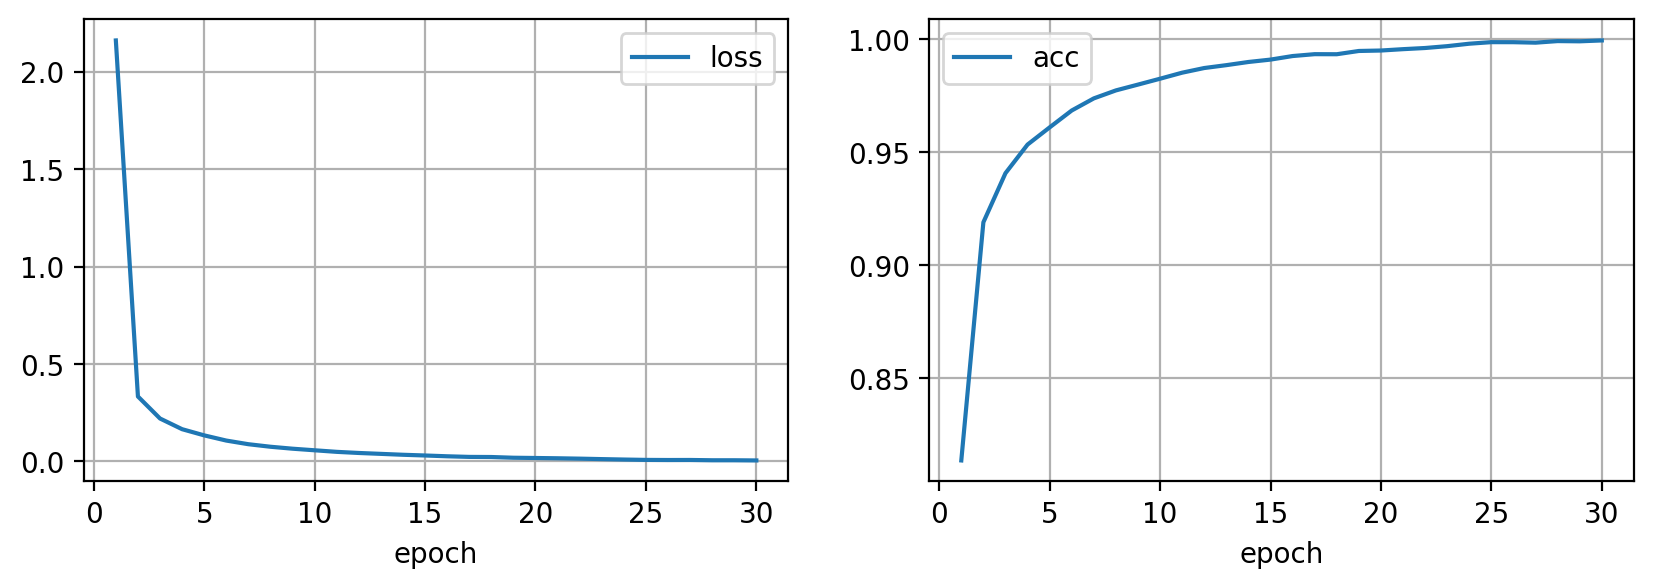

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y='loss', grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y='acc', grid=True, ax=ax)
plt.show()

El conjunto de validación

In [8]:
def train(model, epochs = 30, batch_size=1000, dataloader = None, log_each = 10, optimizer = None, scheduler=None):
	if dataloader is None:
		dataset = {
			"train": Dataset(X[:60000], Y[:60000]), # 60.000 imágenes para entrenamiento
			"val": Dataset(X[60000:], Y[60000:])    # 10.000 imágenes para validación
		}
		dataloader = {
			'train': torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
			'val': torch.utils.data.DataLoader(dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True)
		}
	model.cuda()
	criterion = torch.nn.CrossEntropyLoss()
	if optimizer is None:
		optimizer = torch.optim.Adam(model.parameters())
	l, acc, lr = [], [], []
	val_l, val_acc = [], []
	for e in range(1, epochs+1):
		_l, _acc = [], []
		for param_group in optimizer.param_groups:
			lr.append(param_group['lr'])
		# entrenamiento
		model.train()
		for batch_ix, (x, y) in enumerate(dataloader['train']):
			x, y = x.cuda(), y.cuda()
			optimizer.zero_grad()
			with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
				y_pred = model(x)
				loss = criterion(y_pred, y)
			_l.append(loss.item())
			y_probas = torch.argmax(softmax(y_pred), axis=1)
			_acc.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().detach().numpy()))
			loss.backward()
			optimizer.step()
		l.append(np.mean(_l))
		acc.append(np.mean(_acc))
		loss, current = loss.item(), (batch_ix + 1) * len(x)
		# validación
		model.eval()
		_l, _acc = [], []
		with torch.no_grad():
			for batch_ix, (x, y) in enumerate(dataloader['val']):
				x, y = x.cuda(), y.cuda()
				with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
					y_pred = model(x)
					loss = criterion(y_pred, y)
					_l.append(loss.item())
					y_probas = torch.argmax(softmax(y_pred), axis=1)
					_acc.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().numpy()))
		val_l.append(np.mean(_l))
		val_acc.append(np.mean(_acc))
		if scheduler:
			scheduler.step()
		if e % log_each == 0:
			print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
	return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [9]:
model = build_model()
hist = train(model, log_each=1)

Epoch 1/30 loss 2.19903 acc 0.82018 val_loss 0.44493 val_acc 0.90600
Epoch 2/30 loss 0.33723 acc 0.92272 val_loss 0.29828 val_acc 0.92680
Epoch 3/30 loss 0.21416 acc 0.94332 val_loss 0.24127 val_acc 0.94030
Epoch 4/30 loss 0.15488 acc 0.95678 val_loss 0.21230 val_acc 0.94560
Epoch 5/30 loss 0.12073 acc 0.96525 val_loss 0.20011 val_acc 0.94690
Epoch 6/30 loss 0.09466 acc 0.97217 val_loss 0.18121 val_acc 0.95260
Epoch 7/30 loss 0.07807 acc 0.97622 val_loss 0.17409 val_acc 0.95390
Epoch 8/30 loss 0.06515 acc 0.98022 val_loss 0.17251 val_acc 0.95610
Epoch 9/30 loss 0.05235 acc 0.98380 val_loss 0.17164 val_acc 0.95640
Epoch 10/30 loss 0.04500 acc 0.98660 val_loss 0.16387 val_acc 0.95960
Epoch 11/30 loss 0.03792 acc 0.98843 val_loss 0.16398 val_acc 0.96040
Epoch 12/30 loss 0.03188 acc 0.98975 val_loss 0.16656 val_acc 0.96130
Epoch 13/30 loss 0.02694 acc 0.99207 val_loss 0.17146 val_acc 0.96180
Epoch 14/30 loss 0.02383 acc 0.99287 val_loss 0.16530 val_acc 0.96180
Epoch 15/30 loss 0.01894 acc 

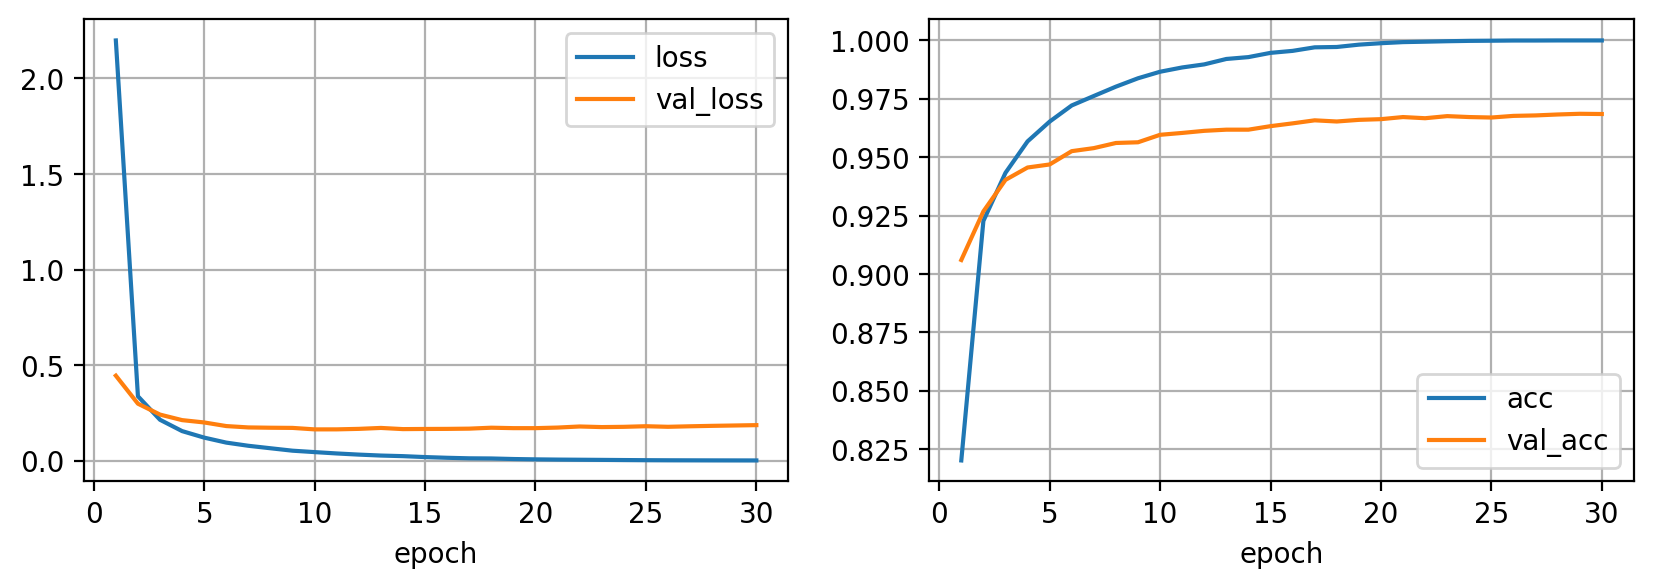

In [13]:
def plot_hist(hist):
    fig = plt.figure(dpi=200, figsize=(10,3))
    ax = plt.subplot(121)
    pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
    ax = plt.subplot(122)
    pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
    plt.show()

plot_hist(hist)

Capacidad del modelo

In [14]:
model = build_model(H=3)

hist = train(model, epochs=10, log_each=1)

Epoch 1/10 loss 2.81222 acc 0.10400 val_loss 2.35465 val_acc 0.10280
Epoch 2/10 loss 2.34597 acc 0.10442 val_loss 2.33969 val_acc 0.10280
Epoch 3/10 loss 2.33470 acc 0.10442 val_loss 2.33258 val_acc 0.10280
Epoch 4/10 loss 2.32562 acc 0.10442 val_loss 2.32395 val_acc 0.10280
Epoch 5/10 loss 2.31897 acc 0.10442 val_loss 2.31519 val_acc 0.10280
Epoch 6/10 loss 2.31366 acc 0.10442 val_loss 2.31285 val_acc 0.10280
Epoch 7/10 loss 2.30944 acc 0.10442 val_loss 2.31040 val_acc 0.10280
Epoch 8/10 loss 2.30730 acc 0.10442 val_loss 2.30348 val_acc 0.10280
Epoch 9/10 loss 2.30471 acc 0.10442 val_loss 2.30297 val_acc 0.10280
Epoch 10/10 loss 2.30445 acc 0.10442 val_loss 2.30382 val_acc 0.10280


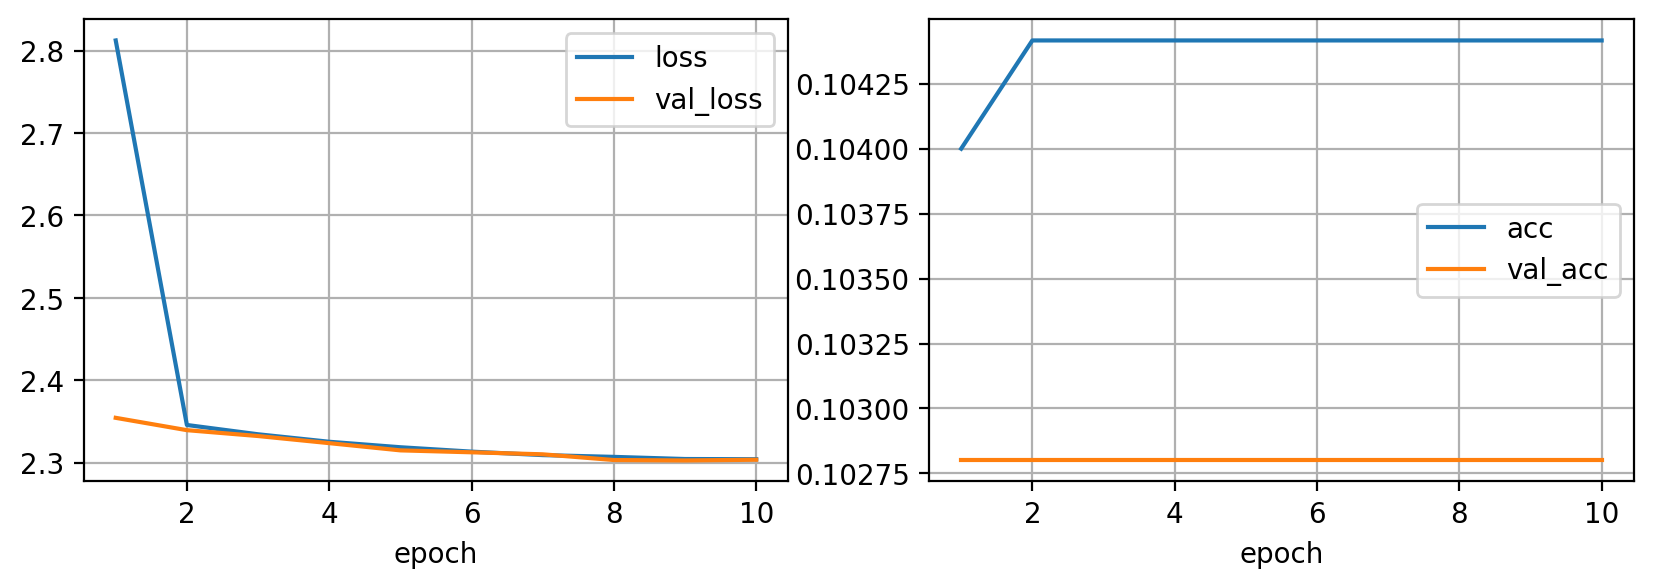

In [15]:
plot_hist(hist)

Validación cruzada

In [16]:
from sklearn.model_selection import KFold

FOLDS = 5
kf = KFold(n_splits=FOLDS)

# separamos en train y test
X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., Y[:60000], Y[60000:]

X_train.shape, X_test.shape, kf.get_n_splits(X)

((60000, 784), (10000, 784), 5)

In [17]:
train_accs, val_accs = [], []
models = []
# hacemos validación cruzada con datos de train
for k, (train_index, val_index) in enumerate(kf.split(X_train)):
    print("Fold:", k+1)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    dataset = {
        'train': Dataset(X_train_fold, y_train_fold),
        'val': Dataset(X_val_fold, y_val_fold)
    }
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    model = build_model()
    models.append(model)
    hist = train(model, dataloader=dataloader)
    train_accs.append(hist['acc'][-1])
    val_accs.append(hist['val_acc'][-1])

Fold: 1
Epoch 10/30 loss 0.03605 acc 0.99000 val_loss 0.08172 val_acc 0.97617
Epoch 20/30 loss 0.00603 acc 0.99923 val_loss 0.09462 val_acc 0.97633
Epoch 30/30 loss 0.00706 acc 0.99806 val_loss 0.10772 val_acc 0.97758
Fold: 2
Epoch 10/30 loss 0.03796 acc 0.98973 val_loss 0.09289 val_acc 0.97125
Epoch 20/30 loss 0.00735 acc 0.99881 val_loss 0.10024 val_acc 0.97383
Epoch 30/30 loss 0.00402 acc 0.99906 val_loss 0.11444 val_acc 0.97458
Fold: 3
Epoch 10/30 loss 0.03756 acc 0.98933 val_loss 0.09318 val_acc 0.97175
Epoch 20/30 loss 0.00691 acc 0.99879 val_loss 0.10214 val_acc 0.97350
Epoch 30/30 loss 0.00758 acc 0.99781 val_loss 0.12294 val_acc 0.97458
Fold: 4
Epoch 10/30 loss 0.03476 acc 0.99010 val_loss 0.10152 val_acc 0.97017
Epoch 20/30 loss 0.00656 acc 0.99902 val_loss 0.11420 val_acc 0.97125
Epoch 30/30 loss 0.00071 acc 1.00000 val_loss 0.13117 val_acc 0.97350
Fold: 5
Epoch 10/30 loss 0.03892 acc 0.98929 val_loss 0.08731 val_acc 0.97375
Epoch 20/30 loss 0.00720 acc 0.99877 val_loss 0.09

In [18]:
np.mean(train_accs), np.std(train_accs)

(0.9989791666666668, 0.0009175185435606895)

In [19]:
np.mean(val_accs), np.std(val_accs)

(0.9755333333333333, 0.001654623152798799)

El conjunto de test

In [20]:
dataset = { 'test': Dataset(X_test, y_test) }
dataloader = { 'test': torch.utils.data.DataLoader(dataset['test'], batch_size=100) }
test_accs = []
with torch.no_grad():
	for model in models:
		model.eval()
		preds = torch.tensor([]).cuda()
		for batch_ix, (x, y) in enumerate(dataloader['test']):
			x, y = x.cuda(), y.cuda()
			with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
				y_pred = model(x)
				preds = torch.cat([preds, y_pred])
		preds = torch.mean(preds, axis=0)	
		y_probas = torch.argmax(softmax(y_pred), axis=1)
		test_accs.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().numpy()))

np.mean(test_accs), np.std(test_accs)

(0.982, 0.011661903789690611)

## Optimización

In [21]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.25126 acc 0.93213 val_loss 0.29088 val_acc 0.92490
Epoch 20/30 loss 0.16636 acc 0.95325 val_loss 0.22654 val_acc 0.94090
Epoch 30/30 loss 0.12810 acc 0.96293 val_loss 0.20082 val_acc 0.94690


In [22]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.14680 acc 0.95623 val_loss 0.17489 val_acc 0.94710
Epoch 20/30 loss 0.10139 acc 0.96957 val_loss 0.14493 val_acc 0.95700
Epoch 30/30 loss 0.07769 acc 0.97708 val_loss 0.13857 val_acc 0.96230


In [23]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.16192 acc 0.95355 val_loss 0.19640 val_acc 0.95240
Epoch 20/30 loss 0.33085 acc 0.95032 val_loss 0.16879 val_acc 0.96240
Epoch 30/30 loss 0.02514 acc 0.99193 val_loss 0.18367 val_acc 0.96450


In [24]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.06867 acc 0.97923 val_loss 0.20082 val_acc 0.95420
Epoch 20/30 loss 0.01865 acc 0.99533 val_loss 0.19370 val_acc 0.96200
Epoch 30/30 loss 0.00540 acc 0.99940 val_loss 0.20568 val_acc 0.96290


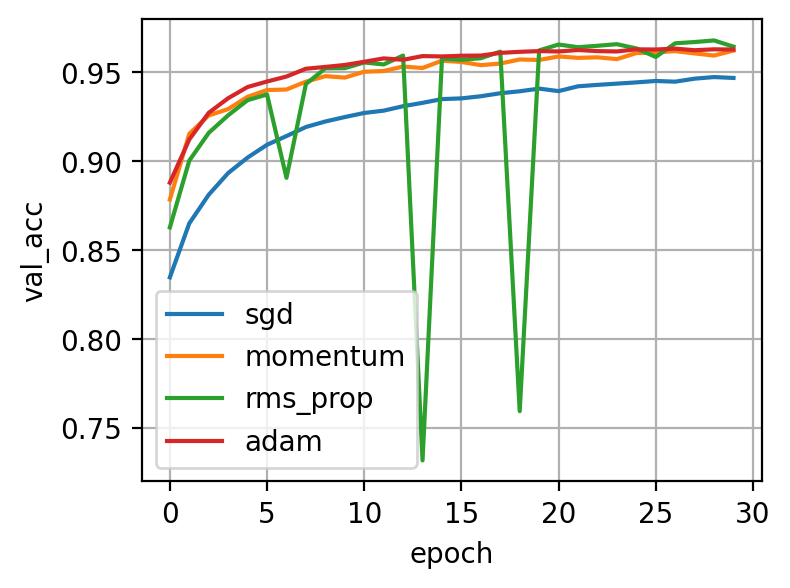

In [25]:
fig = plt.figure(dpi=200, figsize=(4,3))
ax = plt.subplot(111)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('val_acc')
ax.set_xlabel('epoch')
plt.show()

## Transfer Learning

In [1]:
import wget

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers (1).zip'

In [2]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
import os

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['tulip', 'dandelion', 'rose', 'sunflower', 'daisy']

In [4]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: tulip. Imágenes: 984
Categoría: dandelion. Imágenes: 1055
Categoría: rose. Imágenes: 784
Categoría: sunflower. Imágenes: 734
Categoría: daisy. Imágenes: 769


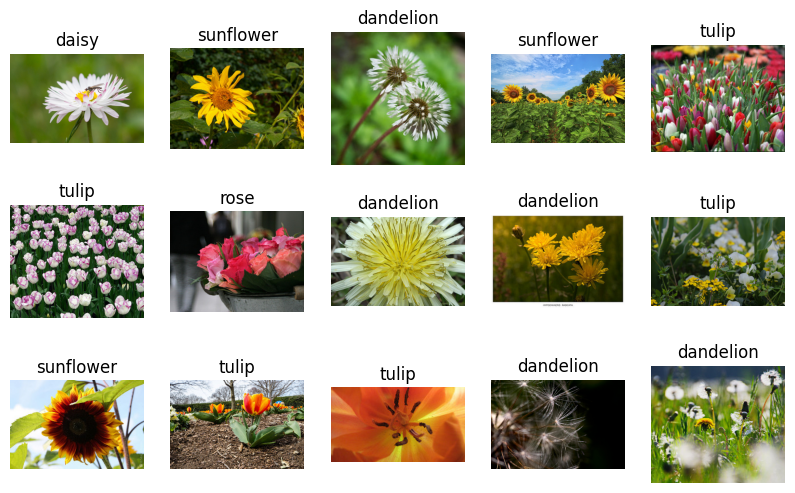

In [5]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

In [7]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imagen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [8]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

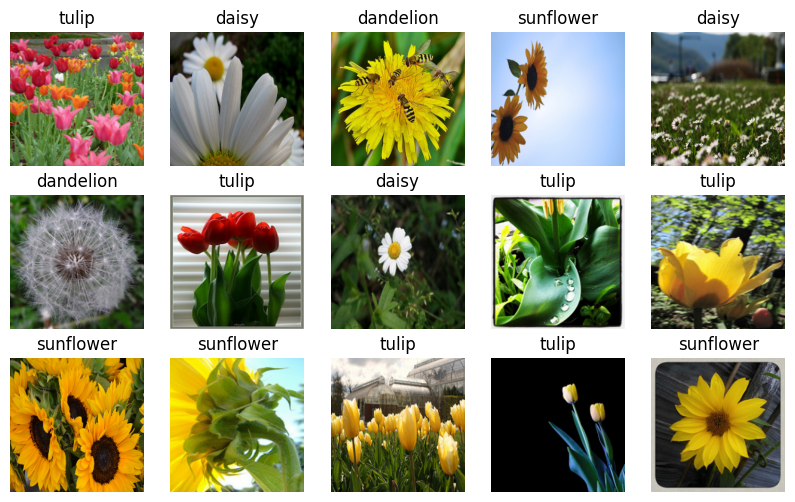

In [9]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [10]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [11]:
import torchvision

resnet = torchvision.models.resnet18()

In [12]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, n_outputs)
    self.freeze = freeze

  def forward(self, x):
    if self.freeze:
      with torch.no_grad():
        x = self.resnet(x)
    else:
      x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    self.freeze = False
    for param in self.resnet.parameters():
        param.requires_grad=True

In [13]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

In [14]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [15]:
model = Model()
fit(model, dataloader, epochs=15)

val_loss 1.55262 val_acc 0.34544: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Epoch 1/15 loss 1.36404 val_loss 1.55262 acc 0.40767 val_acc 0.34544


val_loss 1.49975 val_acc 0.38610: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 2/15 loss 1.13691 val_loss 1.49975 acc 0.54545 val_acc 0.38610


val_loss 2.37912 val_acc 0.33603: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 3/15 loss 1.02629 val_loss 2.37912 acc 0.59801 val_acc 0.33603


val_loss 1.77862 val_acc 0.44258: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 4/15 loss 0.96347 val_loss 1.77862 acc 0.62386 val_acc 0.44258


val_loss 33.50848 val_acc 0.21799: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 5/15 loss 0.92299 val_loss 33.50848 acc 0.65114 val_acc 0.21799


val_loss 2.48600 val_acc 0.32626: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 6/15 loss 0.93814 val_loss 2.48600 acc 0.64290 val_acc 0.32626


val_loss 1.13676 val_acc 0.57917: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 7/15 loss 0.84660 val_loss 1.13676 acc 0.68494 val_acc 0.57917


val_loss 2.95990 val_acc 0.33665: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 8/15 loss 0.77974 val_loss 2.95990 acc 0.69688 val_acc 0.33665


val_loss 13.35223 val_acc 0.16854: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 9/15 loss 0.78652 val_loss 13.35223 acc 0.69176 val_acc 0.16854


val_loss 4.02499 val_acc 0.19147: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 10/15 loss 0.79217 val_loss 4.02499 acc 0.70625 val_acc 0.19147


val_loss 2.97817 val_acc 0.32385: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 11/15 loss 0.70427 val_loss 2.97817 acc 0.72955 val_acc 0.32385


val_loss 2.53763 val_acc 0.38798: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch 12/15 loss 0.66151 val_loss 2.53763 acc 0.75199 val_acc 0.38798


val_loss 3.59830 val_acc 0.25779: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 13/15 loss 0.63154 val_loss 3.59830 acc 0.75568 val_acc 0.25779


val_loss 9.01252 val_acc 0.28185: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 14/15 loss 0.57465 val_loss 9.01252 acc 0.79744 val_acc 0.28185


val_loss 2.18496 val_acc 0.51043: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

Epoch 15/15 loss 0.55840 val_loss 2.18496 acc 0.79460 val_acc 0.51043


In [16]:
model = Model(pretrained=True, freeze=True)

fit(model, dataloader)

/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.99382 val_acc 0.63085: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 1/5 loss 1.09972 val_loss 0.99382 acc 0.59915 val_acc 0.63085


val_loss 0.73541 val_acc 0.72986: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch 2/5 loss 0.65730 val_loss 0.73541 acc 0.80739 val_acc 0.72986


val_loss 0.64844 val_acc 0.73838: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Epoch 3/5 loss 0.54075 val_loss 0.64844 acc 0.83210 val_acc 0.73838


val_loss 0.52652 val_acc 0.82072: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 4/5 loss 0.47583 val_loss 0.52652 acc 0.85369 val_acc 0.82072


val_loss 0.52154 val_acc 0.81138: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]

Epoch 5/5 loss 0.44398 val_loss 0.52154 acc 0.86278 val_acc 0.81138


In [17]:
model = Model(pretrained=True, freeze=False)

fit(model, dataloader)

val_loss 1.19993 val_acc 0.45387: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 1/5 loss 0.79710 val_loss 1.19993 acc 0.74148 val_acc 0.45387


val_loss 0.66716 val_acc 0.72018: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Epoch 2/5 loss 0.38788 val_loss 0.66716 acc 0.87898 val_acc 0.72018


val_loss 0.40409 val_acc 0.85739: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Epoch 3/5 loss 0.27603 val_loss 0.40409 acc 0.90966 val_acc 0.85739


val_loss 0.29276 val_acc 0.87505: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Epoch 4/5 loss 0.18235 val_loss 0.29276 acc 0.95000 val_acc 0.87505


val_loss 0.55638 val_acc 0.80189: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]

Epoch 5/5 loss 0.17698 val_loss 0.55638 acc 0.94261 val_acc 0.80189


In [18]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

val_loss 2.00361 val_acc 0.20948: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch 1/5 loss 1.08278 val_loss 2.00361 acc 0.61562 val_acc 0.20948


val_loss 1.39972 val_acc 0.41321: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch 2/5 loss 0.68078 val_loss 1.39972 acc 0.80682 val_acc 0.41321


val_loss 1.09837 val_acc 0.52394: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 3/5 loss 0.57633 val_loss 1.09837 acc 0.81960 val_acc 0.52394


val_loss 1.06795 val_acc 0.54898: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 4/5 loss 0.49804 val_loss 1.06795 acc 0.85000 val_acc 0.54898


val_loss 0.49924 val_acc 0.81662: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 5/5 loss 0.44308 val_loss 0.49924 acc 0.86193 val_acc 0.81662


val_loss 0.50280 val_acc 0.81111: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 1/5 loss 0.50098 val_loss 0.50280 acc 0.81818 val_acc 0.81111


val_loss 0.44817 val_acc 0.83962: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch 2/5 loss 0.45711 val_loss 0.44817 acc 0.84858 val_acc 0.83962


val_loss 0.43428 val_acc 0.84743: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Epoch 3/5 loss 0.44139 val_loss 0.43428 acc 0.85455 val_acc 0.84743


val_loss 0.42488 val_acc 0.85810: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 4/5 loss 0.42255 val_loss 0.42488 acc 0.86847 val_acc 0.85810


val_loss 0.42119 val_acc 0.85907: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]

Epoch 5/5 loss 0.40933 val_loss 0.42119 acc 0.86364 val_acc 0.85907


In [19]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

## Regularización

In [20]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

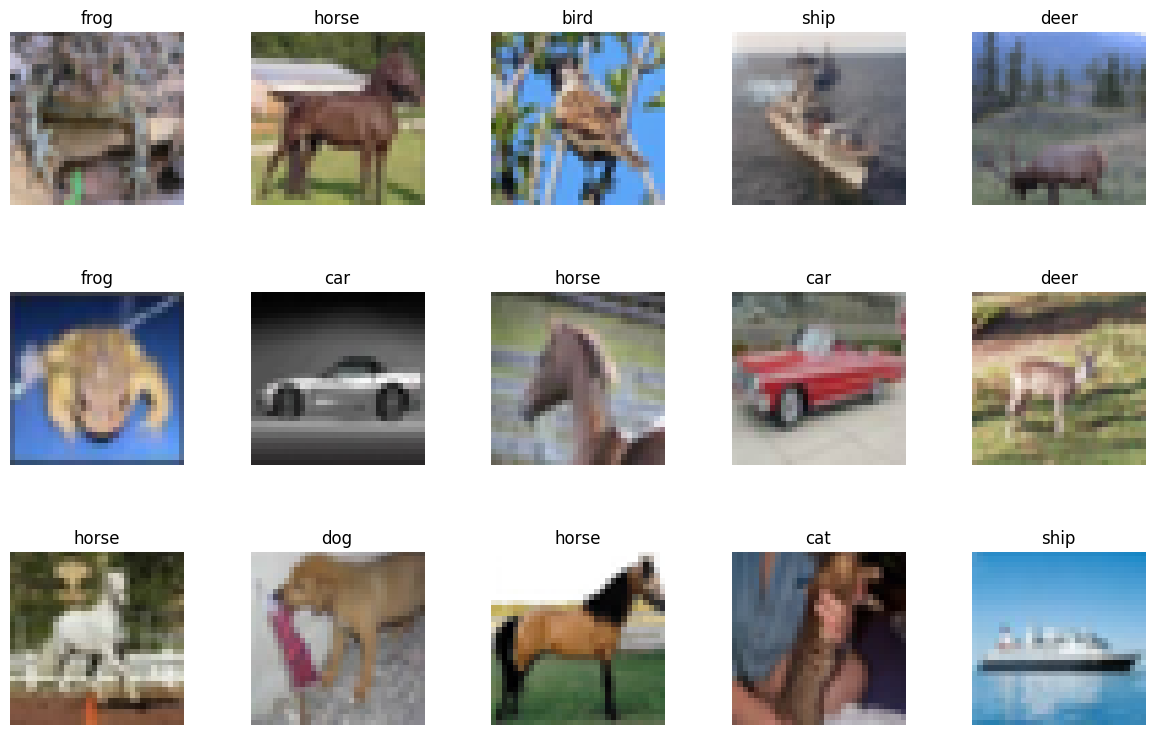

In [21]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [22]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [24]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [25]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 1.71446 acc 0.37878 val_loss 1.86795 val_acc 0.32350
Epoch 20/100 loss 1.50991 acc 0.44705 val_loss 2.30377 val_acc 0.29190
Epoch 30/100 loss 1.33351 acc 0.51513 val_loss 2.15238 val_acc 0.30930
Epoch 40/100 loss 1.17831 acc 0.56588 val_loss 2.82169 val_acc 0.29800
Epoch 50/100 loss 1.00799 acc 0.63575 val_loss 2.47867 val_acc 0.33330
Epoch 60/100 loss 0.90736 acc 0.66959 val_loss 3.10109 val_acc 0.30050
Epoch 70/100 loss 0.79335 acc 0.71537 val_loss 2.93923 val_acc 0.36190
Epoch 80/100 loss 0.69545 acc 0.75498 val_loss 3.39292 val_acc 0.30300
Epoch 90/100 loss 0.78743 acc 0.72731 val_loss 5.13980 val_acc 0.27660
Epoch 100/100 loss 0.69604 acc 0.76393 val_loss 6.52353 val_acc 0.26270


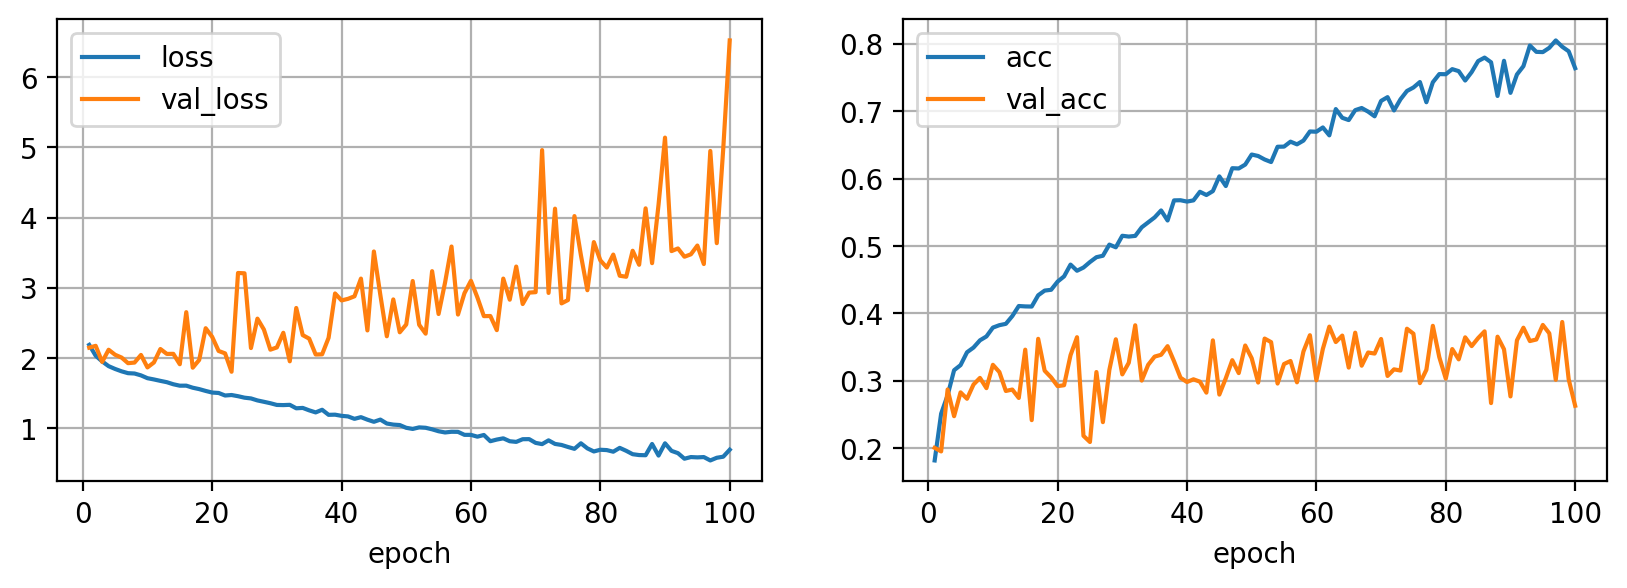

In [26]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

L2

In [27]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)

Epoch 10/100 loss 1.82931 acc 0.33240 val_loss 2.10798 val_acc 0.24530
Epoch 20/100 loss 1.78261 acc 0.35191 val_loss 2.14562 val_acc 0.25670
Epoch 30/100 loss 1.74574 acc 0.36783 val_loss 2.62038 val_acc 0.19070
Epoch 40/100 loss 1.77649 acc 0.36326 val_loss 1.92724 val_acc 0.30310
Epoch 50/100 loss 1.76927 acc 0.36823 val_loss 2.67200 val_acc 0.17770
Epoch 60/100 loss 1.75120 acc 0.37221 val_loss 2.16361 val_acc 0.27840
Epoch 70/100 loss 1.72336 acc 0.37500 val_loss 2.16682 val_acc 0.23000
Epoch 80/100 loss 1.75064 acc 0.37639 val_loss 2.19884 val_acc 0.27550
Epoch 90/100 loss 1.74351 acc 0.36564 val_loss 2.10180 val_acc 0.26210
Epoch 100/100 loss 1.73218 acc 0.37918 val_loss 2.00735 val_acc 0.27920


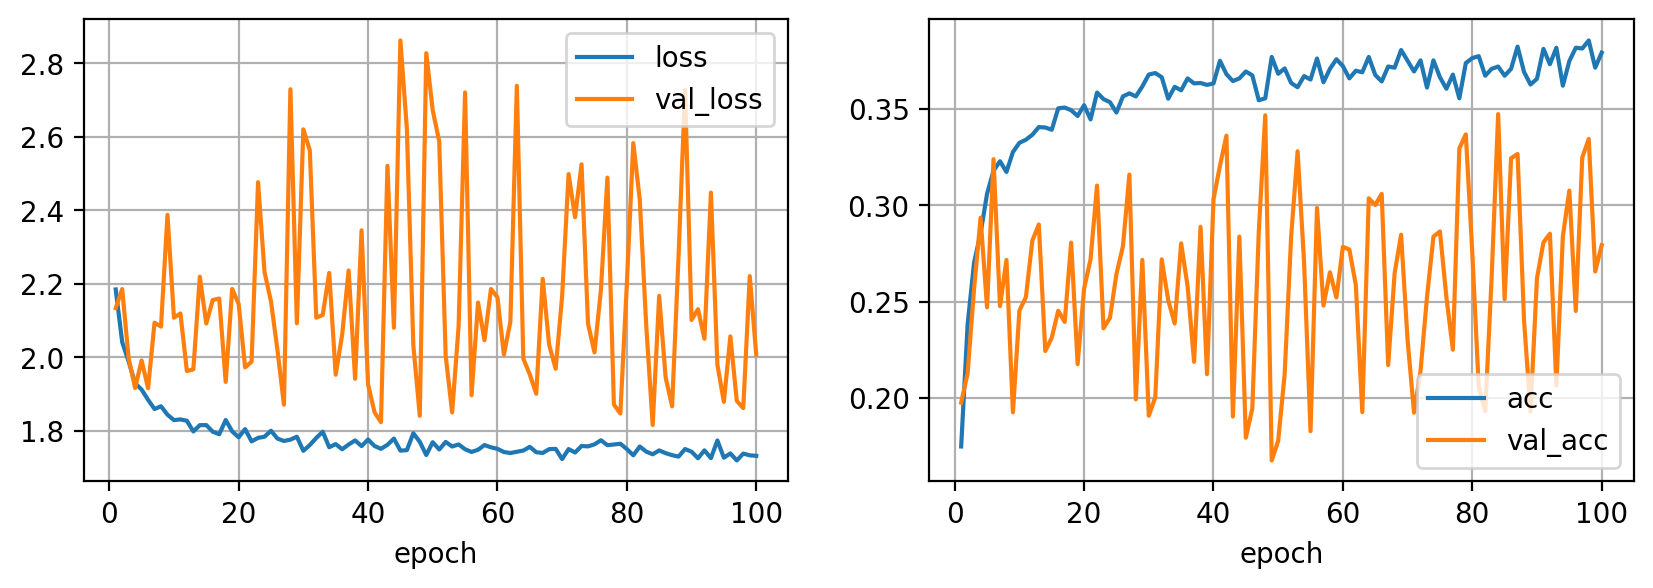

In [28]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Early Stopping

In [29]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [30]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.14570 en epoch 1
Mejor modelo guardado con acc 0.18430 en epoch 2
Mejor modelo guardado con acc 0.21490 en epoch 3
Mejor modelo guardado con acc 0.22870 en epoch 4
Mejor modelo guardado con acc 0.26300 en epoch 5
Mejor modelo guardado con acc 0.29750 en epoch 6
Mejor modelo guardado con acc 0.30490 en epoch 9
Mejor modelo guardado con acc 0.30560 en epoch 10
Epoch 10/100 loss 1.70170 acc 0.37938 val_loss 1.91928 val_acc 0.30560
Mejor modelo guardado con acc 0.31000 en epoch 13
Mejor modelo guardado con acc 0.31890 en epoch 14
Mejor modelo guardado con acc 0.35540 en epoch 15
Epoch 20/100 loss 1.48828 acc 0.45760 val_loss 2.23164 val_acc 0.29310
Entrenamiento detenido en epoch 25 por no mejorar en 10 epochs seguidas


/tmp/ipykernel_57650/3872039596.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


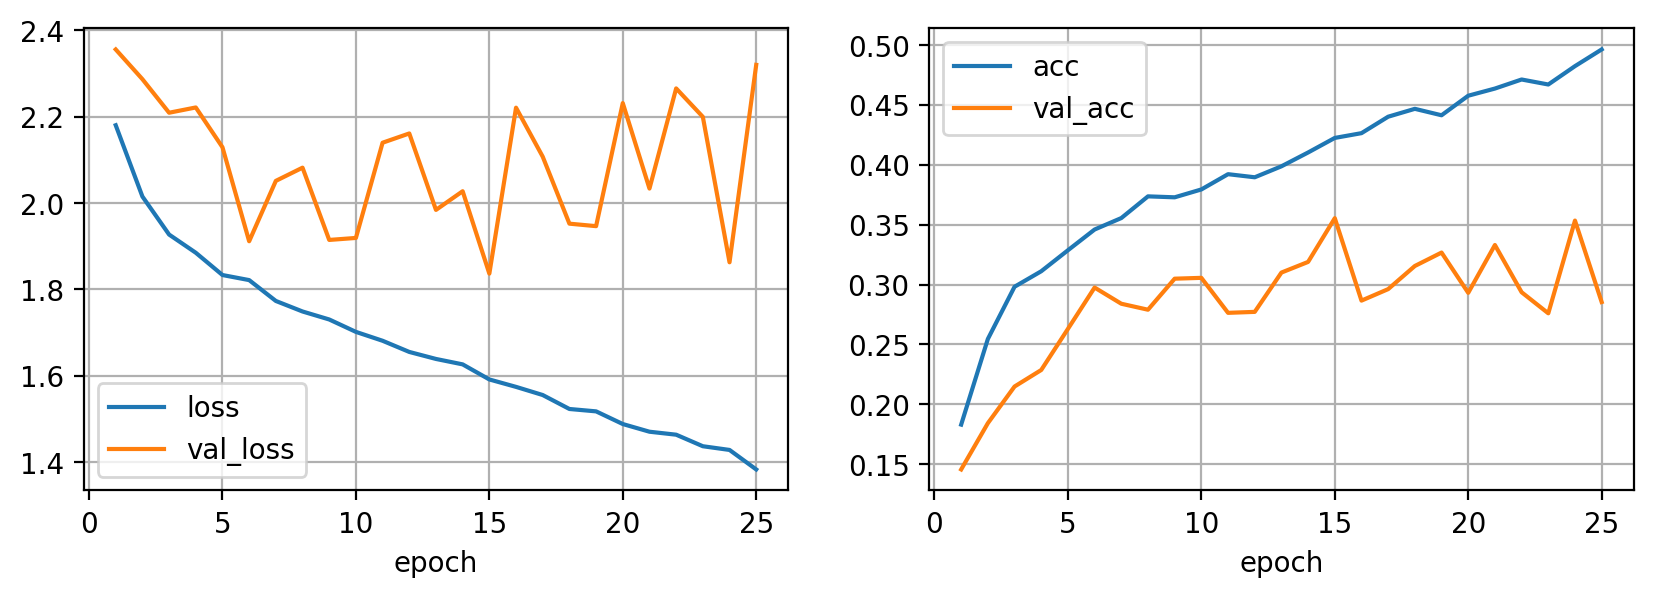

In [31]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()


Dropout

In [32]:
def build_model(D_in=32*32*3, H=100, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [33]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.16010 en epoch 1
Mejor modelo guardado con acc 0.17030 en epoch 3
Mejor modelo guardado con acc 0.20810 en epoch 4
Mejor modelo guardado con acc 0.21200 en epoch 5
Mejor modelo guardado con acc 0.22230 en epoch 6
Mejor modelo guardado con acc 0.23210 en epoch 7
Epoch 10/100 loss 2.08053 acc 0.21079 val_loss 2.03900 val_acc 0.21370
Mejor modelo guardado con acc 0.24450 en epoch 12
Mejor modelo guardado con acc 0.26740 en epoch 13
Epoch 20/100 loss 2.03976 acc 0.23010 val_loss 2.01456 val_acc 0.24980
Mejor modelo guardado con acc 0.26810 en epoch 21
Epoch 30/100 loss 2.01188 acc 0.24363 val_loss 2.01082 val_acc 0.24160
Mejor modelo guardado con acc 0.28640 en epoch 37
Mejor modelo guardado con acc 0.28940 en epoch 38
Epoch 40/100 loss 1.97478 acc 0.26075 val_loss 1.95374 val_acc 0.26410
Mejor modelo guardado con acc 0.29130 en epoch 49
Epoch 50/100 loss 1.95415 acc 0.26811 val_loss 1.94155 val_acc 0.27100
Mejor modelo guardado con acc 0.30210 en epoch 52
M

/tmp/ipykernel_57650/3872039596.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Más datos

In [34]:
# ahora sí que usamos todos los datos

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [35]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.36250 en epoch 1
Mejor modelo guardado con acc 0.38340 en epoch 2
Mejor modelo guardado con acc 0.38970 en epoch 3
Mejor modelo guardado con acc 0.39750 en epoch 4
Mejor modelo guardado con acc 0.42240 en epoch 5
Mejor modelo guardado con acc 0.43480 en epoch 6
Mejor modelo guardado con acc 0.45280 en epoch 8
Epoch 10/100 loss 1.47277 acc 0.47100 val_loss 1.61511 val_acc 0.42710
Mejor modelo guardado con acc 0.46300 en epoch 14
Mejor modelo guardado con acc 0.47690 en epoch 16
Epoch 20/100 loss 1.35239 acc 0.51245 val_loss 1.53498 val_acc 0.46790
Mejor modelo guardado con acc 0.48900 en epoch 21
Epoch 30/100 loss 1.27378 acc 0.54107 val_loss 1.54339 val_acc 0.46650
Entrenamiento detenido en epoch 31 por no mejorar en 10 epochs seguidas


/tmp/ipykernel_57650/3872039596.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


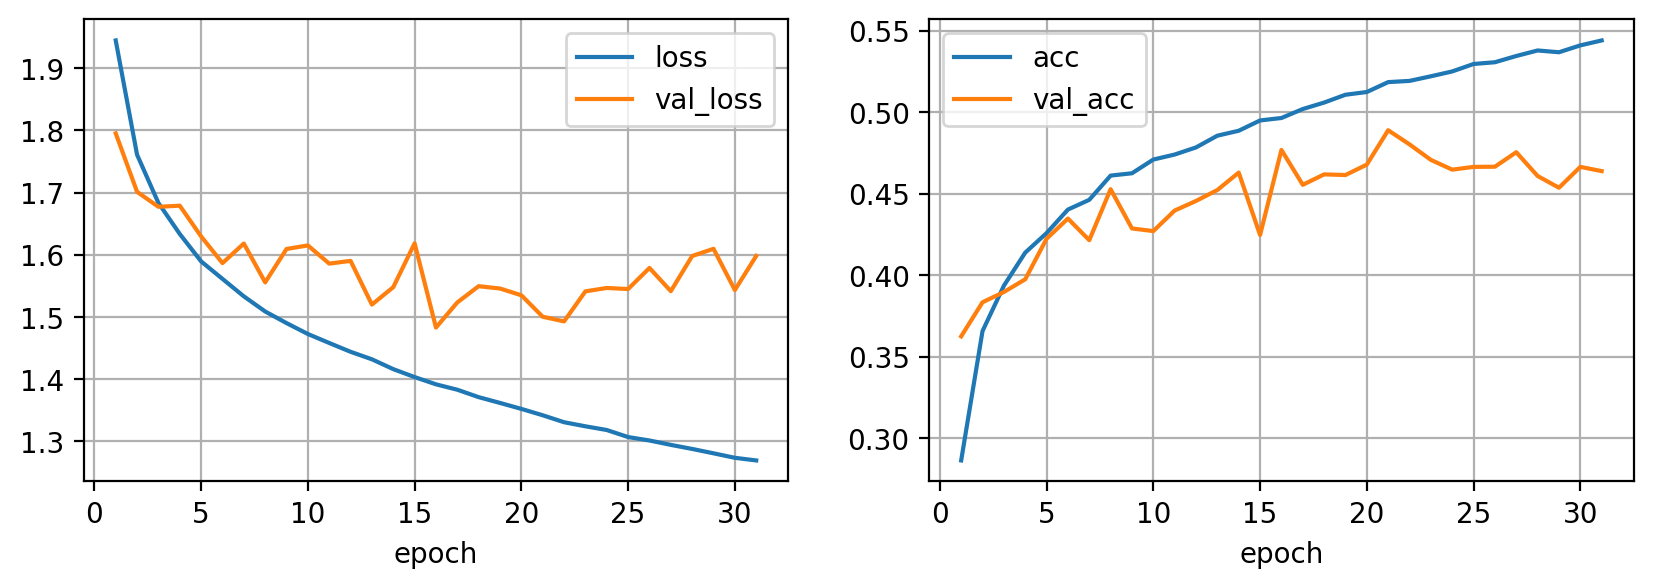

In [36]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Data augmentation

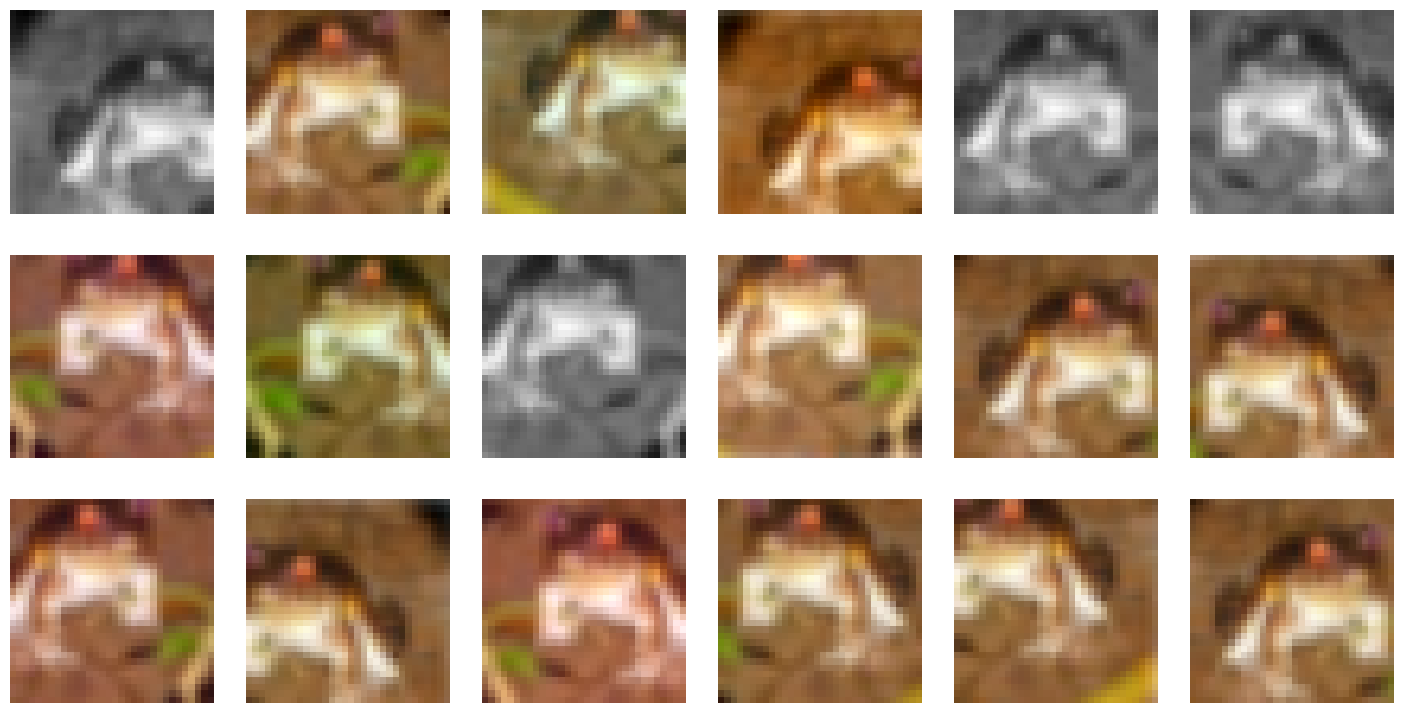

In [37]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

idx = 0
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img, label = trainset[idx]
        # apply transformation
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [38]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().cuda().view(-1)
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label

dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [39]:
model = build_model()
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.31290 en epoch 1
Mejor modelo guardado con acc 0.32120 en epoch 2
Mejor modelo guardado con acc 0.34730 en epoch 4
Mejor modelo guardado con acc 0.35480 en epoch 5
Mejor modelo guardado con acc 0.36110 en epoch 7
Mejor modelo guardado con acc 0.37290 en epoch 8
Mejor modelo guardado con acc 0.38270 en epoch 9
Epoch 10/100 loss 1.81364 acc 0.33842 val_loss 1.74940 val_acc 0.37450
Mejor modelo guardado con acc 0.39310 en epoch 13
Mejor modelo guardado con acc 0.39330 en epoch 14
Mejor modelo guardado con acc 0.41470 en epoch 19
Epoch 20/100 loss 1.75019 acc 0.36523 val_loss 1.75990 val_acc 0.36520
Mejor modelo guardado con acc 0.41760 en epoch 26
Epoch 30/100 loss 1.72723 acc 0.37147 val_loss 1.66277 val_acc 0.40470
Mejor modelo guardado con acc 0.41780 en epoch 31
Mejor modelo guardado con acc 0.42410 en epoch 33
Epoch 40/100 loss 1.70653 acc 0.38385 val_loss 1.62135 val_acc 0.42300
Epoch 50/100 loss 1.69512 acc 0.38622 val_loss 1.64416 val_acc 0.40990
Me

/tmp/ipykernel_57650/3872039596.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


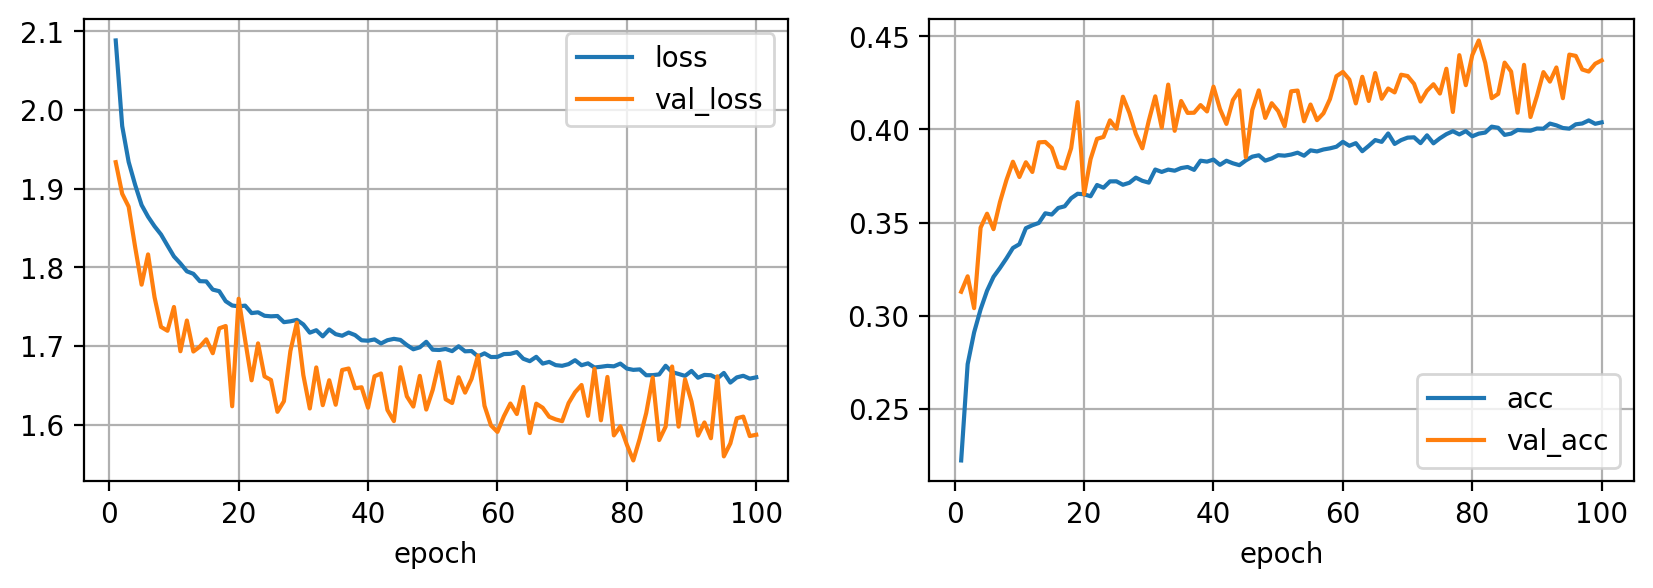

In [40]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()